In [184]:
import os
import pathlib
import nltk
import numpy as np
from unicodedata import normalize
import collections
%reload_ext autoreload
%autoreload 2
from model import *
from simplifier import *

nltk.download('words')
nltk.download('punkt')


AttributeError: module 'nltk' has no attribute 'internals'

In [2]:
path_data = 'data-simplification/wikilarge/wiki.full.aner.'

In [3]:
train_src = open(path_data+'train.src', "r").readlines()
train_dst = open(path_data+'train.dst', "r").readlines()
train_ori_src = open(path_data+'ori.train.src', "r").readlines()
train_ori_dst = open(path_data+'ori.train.dst', "r").readlines()

valid_src = open(path_data+'valid.src', "r").readlines()
valid_dst = open(path_data+'valid.dst', "r").readlines()
valid_ori_src = open(path_data+'ori.valid.src', "r").readlines()
valid_ori_dst = open(path_data+'ori.valid.dst', "r").readlines()

### Comparison of datasets; will work with original first. Named entity identification is applied to get the modified dataset. Might facilitate trainining working with this.

In [4]:
train_src[114]

'ORGANIZATION@1 crews conducted backburning operations to ensure containment of the fire on NUMBER@1 February , warning residents of areas between LOCATION@1 and Warragul about smoke from those fires .\n'

In [5]:
train_ori_src[114]

'DSE crews conducted backburning operations to ensure containment of the fire on 9 February , warning residents of areas between Pakenham and Warragul about smoke from those fires .\n'

In [6]:
train_ori_dst[114]

'People between Pakenham and Warragul were warned about smoke from those fires .\n'

In [7]:
train_dst[114]

'People between LOCATION@1 and Warragul were warned about smoke from those fires .\n'

In [185]:
valid_ori_src[11]

'The Summer of Love became a defining moment of the 1960s , as the hippie counterculture movement came into public awareness .\n'

In [186]:
valid_ori_dst[11]

'Thousands of young people from all over the world went to San Francisco to help create a hippie counterculture . The Summer of Love made the rest of America much more aware of the hippie movement .\n'

In [9]:
embedding_index = {}
file = os.path.join(str(pathlib.Path.home())+"/GloVe","glove.6B.100d.txt")
f= open(file)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embedding_index[word] = coefs



### A glimpse at the representations.

In [10]:
i = 0
for key, value in embedding_index.items():
    if i>5:
        break
    print(key, value)
    print(value.shape)
    i += 1

the [-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.270

In [213]:
from simplifier import *
translator = str.maketrans('', '', string.punctuation)
# line = "There might be something here, or there."
# line = line.translate(translator)
# line
clean(["There might be something, here or  there. Perhaps, it's not too late!"])

'there might be something here or there perhaps its not too late'

In [214]:
clean_txt = clean(train_ori_src)

In [215]:
train_ori_src[0:2]

["There is manuscript evidence that Austen continued to work on these pieces as late as the period 1809 â '' 11 , and that her niece and nephew , Anna and James Edward Austen , made further additions as late as 1814 .\n",
 "In a remarkable comparative analysis , Mandaean scholar Säve-Söderberg demonstrated that Mani 's Psalms of Thomas were closely related to Mandaean texts .\n"]

In [216]:
clean_txt[0:400]

'there is manuscript evidence that austen continued to work on these pieces as late as the period 1809 a 11 and that her niece and nephew anna and james edward austen made further additions as late as 1814in a remarkable comparative analysis mandaean scholar savesoderberg demonstrated that mani s psalms of thomas were closely related to mandaean textsbefore persephone was released to hermes who had'

In [217]:
token_list_src = nltk.word_tokenize(clean_txt)
print(token_list_src[0:30],"\n")
print("Total tokens : ", len(token_list_src))

['there', 'is', 'manuscript', 'evidence', 'that', 'austen', 'continued', 'to', 'work', 'on', 'these', 'pieces', 'as', 'late', 'as', 'the', 'period', '1809', 'a', '11', 'and', 'that', 'her', 'niece', 'and', 'nephew', 'anna', 'and', 'james', 'edward'] 

Total tokens :  6271479


In [15]:
# comparison with source tokens when entities replaced by placeholders
token_list_with_ent_src = nltk.word_tokenize(clean(train_src))
print(token_list_with_ent_src[0:20],"\n")
print("Total tokens : ", len(token_list_with_ent_src))

['there', 'is', 'manuscript', 'evidence', 'that', 'continued', 'to', 'work', 'on', 'these', 'pieces', 'as', 'late', 'as', 'the', 'period', 'a', 'and', 'that', 'her'] 

Total tokens :  4961048


In [218]:
#total vocabulary size in source
len(set(token_list_src))

360639

### Looking at the frequencies

In [219]:

token_list_src_over_threshold = build_vocabulary(tokenize(clean(train_ori_src)), threshold=5)
vocabulary_size_source = len(token_list_src_over_threshold) + 1
print(vocabulary_size_source)
token_list_src_over_threshold[:10]

49395


[('the', 415025),
 ('of', 240217),
 ('in', 187899),
 ('and', 181729),
 ('a', 160024),
 ('is', 120225),
 ('to', 104181),
 ('lrb', 87952),
 ('rrb', 71454),
 ('was', 62169)]

### Which words/tokens from corpus are missing in GloVe; obviously lots of misspelled/not properly separated words.

In [220]:
not_in_GloVe = []
for word, _ in token_list_src_over_threshold:
    if word not in embedding_index:
        not_in_GloVe.append(word)
len(not_in_GloVe)

7526

### Using spell checker a la Norvig

In [19]:
from spellchecker import *

In [20]:
separate_words("umbrellaas", embedding_index)

['umbrella', 'as']

#### Separating a word not in the embedding might give two words in the embedding. Run a couple of times, to see that the number of words not in GloVe decreases

In [233]:
for word in not_in_GloVe:
    if len(separate_words(word, embedding_index))>1:
        not_in_GloVe.remove(word)
        
len(not_in_GloVe)

579

In [234]:
not_in_GloVe[:20]

['pasdecalais',
 'nordpasdecalais',
 'paysdelaloire',
 'provencealpesc',
 'payperview',
 'bouchesdurh',
 'directtovideo',
 'rttemberg',
 'encyclopdia',
 'sseldorf',
 'bouchesdurhone',
 'commanderinchief',
 'provencealpescote',
 'blackandwhite',
 'zaglossus',
 'aurantifolia',
 'urttemberg',
 'seyssinquart',
 'esatlantiques',
 'encyclopa']

In [237]:
improved_token_list = improve_token_list([x[0] for x in token_list_src_over_threshold], \
                                         embedding_index, separate_words)

In [247]:
improved_token_list = improve_token_list([x for x in improved_token_list], \
                                         embedding_index, separate_words)

In [248]:
improved_token_list = list((set(improved_token_list)))
len(improved_token_list)

44461

### Creating token-index-dictionary

In [249]:
tokenizer_src = build_word2index(improved_token_list)

In [250]:
len(tokenizer_src)

44462

In [253]:
import pickle
with open('tokenizer_src.pkl', 'wb') as file:
    pickle.dump(tokenizer_src, file, protocol=pickle.HIGHEST_PROTOCOL)

# #to load
# with open('tokenizer_src.pkl', 'rb') as file:
#     tokenizer_src = pickle.load(file)



True

### embedding matrix to use the GloVe embedding in the model later

In [27]:
embedding_size = 100 # GloVe 100d
vocabulary_size_source = len(tokenizer_src)+1
embedding_matrix = np.zeros((vocabulary_size_source, embedding_size))
for word, idx in tokenizer_src.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [28]:
test = train_ori_src[120]
test

'Sirius left Portsmouth on 13 May 1787 , and arrived at Port Jackson on 26 January 1788 .\n'

In [29]:
len(tokenizer(test))

16

### Let's look at sentence lengths

In [30]:
lengths=[]
lengths = [len((tokenizer(x))) for x in train_ori_src]

In [31]:
print("min", np.min(lengths))
print("mean", np.mean(lengths))
print("max", np.max(lengths))
print("std", np.std(lengths))

min 0
mean 22.678625650299256
max 104
std 11.685398987054729


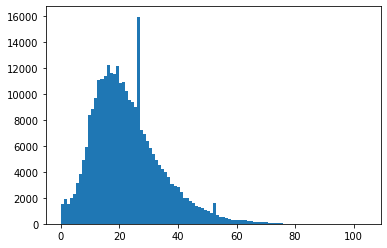

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(lengths, bins=100)
plt.show()
plt.close()

In [33]:
np.argmax(lengths)

26105

In [34]:
np.argmin(lengths)

607

In [35]:
train_ori_src[26105]

'DreamWorks Animation has produced some of the highest grossing animated hits of all time , such as Antz -LRB-/O1998/O-RRB- , The Prince of Egypt -LRB-/O1998/O-RRB- , Shrek -LRB-/O2001/O-RRB- , its sequels Shrek 2 -LRB-/O2004/O-RRB- , Shrek the Third -LRB-/O2007/O-RRB- and Shrek Forever After -LRB-/O2010/O-RRB- ; Shark Tale -LRB-/O2004/O-RRB- , Madagascar -LRB-/O2005/O-RRB- , Over the Hedge -LRB-/O2006/O-RRB- , Flushed Away -LRB-/O2006/O-RRB- , Bee Movie -LRB-/O2007/O-RRB- , Kung Fu Panda -LRB-/O2008/O-RRB- and How to Train Your Dragon -LRB-/O2010/O-RRB- .\n'

In [36]:
train_ori_src[607]

"! ''\n"

In [337]:
sentence_length = max(lengths)
sentence_length

104

In [342]:
train_x = np.array([encode(tokenizer(line), \
                            tokenizer_src, sentence_length, pad=True) for line in \
                    train_ori_src]).reshape(-1, sentence_length)

In [348]:
valid_x = np.array([encode(tokenizer(line), \
                            tokenizer_src, sentence_length, pad=True) for line in \
                    valid_ori_src]).reshape(-1, sentence_length)

In [351]:
train_x.shape

(296402, 104)

In [349]:
valid_x.shape

(992, 104)

In [257]:
get_word(3760, tokenizer_src)

'jumper'

In [258]:
print(train_ori_src[12:13])
print([tokenizer(line) for line in train_ori_src[12:13]])
print(train_x[12:13])

['Plays and comic puppet theater loosely based on this legend were popular throughout Germany in the 16th century , often reducing Faust and Mephistopheles to figures of vulgar fun .\n']
[['plays', 'and', 'comic', 'puppet', 'theater', 'loosely', 'based', 'on', 'this', 'legend', 'were', 'popular', 'throughout', 'germany', 'in', 'the', '16th', 'century', 'often', 'reducing', 'faust', 'and', 'mephistopheles', 'to', 'figures', 'of', 'vulgar', 'fun']]
[list([19836, 34158, 12961, 5118, 1760, 38990, 12622, 14349, 41564, 42102, 9777, 34899, 35495, 31042, 41123, 20862, 44462, 31161, 20562, 44376, 18287, 34158, 5434, 18657, 5447, 15440, 43334, 38851])]


In [352]:
lengths_dst = [len((tokenizer(x))) for x in train_ori_dst]

In [43]:
print("min", np.min(lengths_dst))
print("mean", np.mean(lengths_dst))
print("max", np.max(lengths_dst))
print("std", np.std(lengths_dst))

min 0
mean 16.679013636885042
max 80
std 10.492046320896975


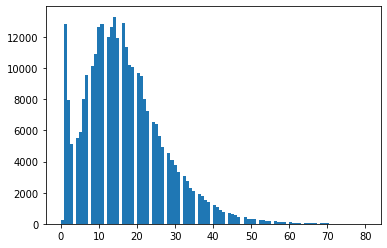

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(lengths_dst, bins=100)
plt.show()
plt.close()

In [353]:
sentence_length_dst = max(lengths_dst)
sentence_length_dst

80

### Look at output vocabulary

In [261]:
token_list_dst_over_threshold = build_vocabulary(tokenize(clean(train_ori_dst)), threshold=3)
vocabulary_size_dst = len(token_list_dst_over_threshold) + 1
print(vocabulary_size_dst)
token_list_dst_over_threshold[:10]

59331


[('the', 301255),
 ('of', 171100),
 ('in', 141875),
 ('a', 120124),
 ('and', 115201),
 ('is', 111754),
 ('to', 70890),
 ('lrb', 60090),
 ('was', 55131),
 ('rrb', 46459)]

In [262]:
improved_token_list_dst = improve_token_list([x[0] for x in token_list_dst_over_threshold], \
                                         embedding_index, separate_words)
improved_token_list_dst = list((set(improved_token_list_dst)))
vocabulary_size_dst = len(improved_token_list_dst) + 1
print(vocabulary_size_dst)

51596


In [281]:
improved_token_list_dst = improve_token_list([x for x in improved_token_list_dst], \
                                         embedding_index, separate_words)
len(improved_token_list_dst), len(set(improved_token_list_dst))

(54605, 49265)

In [282]:
not_in_GloVe = []
for word in improved_token_list_dst:
    if word not in embedding_index:
        not_in_GloVe.append(word)
len(not_in_GloVe)

841

In [292]:
tokenizer_dst = build_word2index(improved_token_list_dst, add_toc=True)
vocabulary_size_dst = len(tokenizer_dst)+1
vocabulary_size_dst

49269

In [286]:
import pickle
with open('tokenizer_dst.pkl', 'wb') as file:
    pickle.dump(tokenizer_dst, file, protocol=pickle.HIGHEST_PROTOCOL)

# #to load
# with open('tokenizer_dst.pkl', 'rb') as file:
#     tokenizer_dst = pickle.load(file)



In [354]:
train_y = np.array([encode(tokenizer(line, add_toc=True), \
                            tokenizer_dst, sentence_length_dst, pad=True) for line in \
                    train_ori_dst]).reshape(-1, sentence_length_dst)

In [355]:
valid_y = np.array([encode(tokenizer(line, add_toc=True), \
                            tokenizer_dst, sentence_length_dst, pad=True) for line in \
                    valid_ori_dst]).reshape(-1, sentence_length_dst)

In [356]:
train_y.shape

(296402, 80)

In [357]:
valid_y.shape

(992, 80)

In [290]:
train_ori_dst[0]

'There is some proof that Austen continued to work on these pieces later in life . Her nephew and niece , James Edward and Anna Austen , may have made further additions to her work in around 1814 .\n'

In [291]:
train_y[0:3]

array([list([49267, 35946, 32151, 8323, 45620, 13983, 4606, 12549, 20717, 35842, 15926, 21393, 5319, 32786, 45585, 37530, 22371, 44678, 37800, 44892, 18101, 6517, 37800, 14101, 4606, 32490, 32628, 25127, 21467, 32288, 20717, 22371, 35842, 45585, 34168, 35404, 49268]),
       list([49267, 29596, 23884, 15188, 49266, 43412, 13983, 28833, 11141, 24160, 17145, 8381, 10825, 39013, 44996, 20717, 29596, 5154, 49268]),
       list([49267, 7119, 1240, 20749, 20717, 23105, 33107, 20717, 23282, 22371, 33970, 48740, 34438, 33970, 20717, 6619, 23105, 9128, 31112, 35233, 4577, 46079, 43209, 36886, 1409, 46298, 20717, 44567, 22371, 45585, 23105, 33107, 25652, 48740, 39222, 35233, 4267, 46060, 34438, 20717, 11776, 25549, 49268])],
      dtype=object)

In [51]:
from tensorflow.keras.callbacks import Callback
class NeptuneMonitor(Callback):
    def on_epoch_end(self, epoch, logs={}):
        my_metric = logs['loss']
        neptune.send_metric('Sparse Categorical Cross Entropy', epoch, my_metric)

In [52]:
from model import *
from simplifier import *

In [358]:
model, encoder_model, decoder_model = build_ed_model(vocabulary_size_source, vocabulary_size_dst, sentence_length, \
                       sentence_length_dst, 256, use_emb=None, unfreeze_emb=True)

In [359]:
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 256)    12645376    input_9[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 256)    12612864    input_10[0][0]                   
____________________________________________________________________________________________

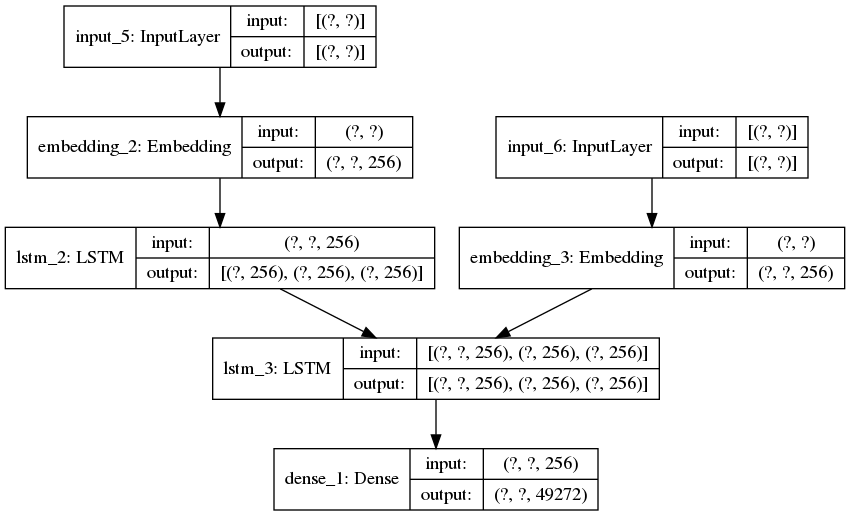

In [295]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [360]:
rms = optimizers.RMSprop(lr=0.0003)
nadm =optimizers.Nadam(learning_rate=0.008, beta_1=0.99, beta_2=0.99999)
admx = optimizers.Adamax(learning_rate=0.0006, beta_1=0.999, beta_2=0.999999)
model.compile(
    optimizer=rms,
    #optimizer="adam",
    #loss="categorical_crossentropy",
    loss="categorical_crossentropy",
    #metrics=["accuracy"]
)


In [ ]:
batch_size = 16
n_samples = 320 #train_x.shape[0]
history = model.fit_generator(
    generator_ed(train_x, train_y, batch_size, vocabulary_size_source, vocabulary_size_dst, \
                 samples=n_samples, shf=False, onehot_dst=True, onehot_src=False),
    #data_gen,
    #(train_gen(train_x, 500), one_hot_encode_output(train_y_gen)),
    epochs=100,
    #batch_size=50,
    #validation_split=0.2,
    #steps_per_epoch = train_x.shape[0]/batch_size,
    steps_per_epoch=n_samples/batch_size,
    validation_data=generator_ed(valid_x, valid_y, batch_size, vocabulary_size_source, vocabulary_size_dst, \
                samples=n_samples, shf=True, onehot_dst=True, onehot_src=False),
    validation_steps=batch_size,
  #  callbacks=[neptune_monitor]
    

)

Epoch 1/100
20/20 [==============================] - 93s 5s/step - loss: 2.3434 - val_loss: 2.0806
Epoch 2/100
20/20 [==============================] - 89s 4s/step - loss: 1.6791 - val_loss: 1.7298
Epoch 3/100
20/20 [==============================] - 89s 4s/step - loss: 1.4573 - val_loss: 1.7296
Epoch 4/100
20/20 [==============================] - 90s 5s/step - loss: 1.4055 - val_loss: 1.7267
Epoch 5/100
20/20 [==============================] - 89s 4s/step - loss: 1.3815 - val_loss: 1.7418
Epoch 6/100
18/20 [==========================>...] - ETA: 7s - loss: 1.3812 

In [109]:
import pickle
with open('trainHistory_320_100ep', 'wb') as file_pi:
        pickle.dump(hist1, file_pi)

In [52]:
from tensorflow.keras.models import load_model
 
model = load_model('model_ed_3200_150ep.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    6721536     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    5035008     input_2[0][0]                    
______________________________________________________________________________________________

In [77]:
np.argmax(model.predict([train_x[0:1], train_y[0:1,1:]]), axis=2)[0]

array([19665, 13799, 17397, 13740,   698, 13462, 18006, 13462, 14577,
        8669, 12959, 17397,  1034, 16109, 12252, 17397, 12562,  1506,
       10519,  1506,  3146,  1506,  3146, 13462, 13462, 14684, 16109,
       13462, 16109, 16109, 13462, 15203, 19665, 19665,     0,     0,
           0,     0,     0])

In [141]:
print([get_word(x, tokenizer_dst) for x in np.argmax(model.predict([train_x[3:4], train_y[3:4,:]]), axis=2)[0]])

['plants', 'are', 'commonly', 'found', 'in', 'district', 'heating', 'systems', 'of', 'big', 'towns', 'hospitals', 'prisons', 'oil', '<UNK>', 'paper', 'mills', '<UNK>', 'treatment', 'plants', 'thermal', 'enhanced', 'oil', 'recovery', 'wells', 'and', 'industrial', 'plants', 'with', 'large', 'heating', 'needs', '<END>', None, None, None, None, None, None, None]


In [98]:
train_ori_dst[3:4]

['Cogeneration plants are commonly found in district heating systems of big towns , hospitals , prisons , oil refineries , paper mills , wastewater treatment plants , thermal enhanced oil recovery wells and industrial plants with large heating needs .\n']

In [142]:
import pdb
indx = 18
sequence = train_x[indx:indx+1]
token_dict = tokenizer_dst
token_dict_reverse = dict((index, word) for word, index in token_dict.items())
token_dict_reverse[0] = '<pad>'
length_out = 50     
enc = encoder_model
dec = decoder_model
states_value = enc.predict(sequence)

# Generate empty target sequence of length 1.
decoded_sequence = np.zeros((1,1))

# Populate the first character of target sequence with the start character.
decoded_sequence[0, 0] = token_dict['<START>']

# Sampling loop for a batch of sequences
# (to simplify, here we assume a batch of size 1).
stop_condition = False
decoded_sentence = ''

while not stop_condition:
    #print(decoded_sequence)
    #print(states_value[1].shape)
    #output_tokens, h, c = decoder_model.predict([decoded_sequence] + states_value)
    output_tokens, hh, cc = dec.predict([decoded_sequence[0]] + states_value)
    #pdb.set_trace()
    #print(output_tokens.shape)
    # Sample a token
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
#     sampled_token_index = np.argmax(output_tokens, axis=2)[0][0]
#     print(sampled_token_index)
    sampled_word = token_dict_reverse[sampled_token_index]
    decoded_sentence += ' '+sampled_word

    # Exit condition: either hit max length or find stop token.
    if (sampled_word == '<END>' or len(decoded_sentence) > length_out):
        stop_condition = True

    # Update the target sequence (of length 1).
    decoded_sequence = np.zeros((1,1))
    decoded_sequence[0, 0] = sampled_token_index

    # Update states
    states_value = [hh, cc]
decoded_sentence

' signal in biology a is continued mechanism <pad> t'

In [143]:
train_ori_dst[indx:indx+1]

['A signal transduction in biology , is a cellular mechanism .\n']

In [91]:
train_x[19:20]

array([[12214, 19938,  9052, 12214,  8560, 17237, 17051, 16711, 24271,
        26058,  9052, 12214, 12619, 19938,  9052, 12214,  4127,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]], dtype=int32)

In [111]:

decode_sequence(train_x[indx:indx+1], enc, dec, token_dict)

' signal in is proof to work these on these on these'

In [167]:
from model import *
indx = 21
# hyp = decode_sequence(train_x[indx:indx+1], enc, dec, token_dict)
# ref = tokenize(clean(train_ori_dst[indx:indx+1]))
hyp = tokenize("oil is good")
ref = ["oil is good many"]

bleu_score(ref, hyp)

0.0

In [177]:
ssent = "About 95 species are currently accepted ."
csent = "About 95 species are known ."
rsent = "About 95 species are currently known ."

from SARI import *
SARIsent(ssent, csent, [rsent])

0.6027417027417027

In [178]:
easse

[autoreload of nltk.internals failed: Traceback (most recent call last):
  File "/home/filipp/anaconda3/envs/simple-simplifier/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/filipp/anaconda3/envs/simple-simplifier/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/filipp/anaconda3/envs/simple-simplifier/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/filipp/anaconda3/envs/simple-simplifier/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/home/filipp/anaconda3/envs/simple-simplifier/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
  File "/home/filipp/anaconda3/envs/simple-simplifier/lib/py

NameError: name 'easse' is not defined

In [179]:
indx = 19
bleu_score(decode_sequence(train_x[indx:indx+1], enc, dec, token_dict), \
           tokenize(clean(train_ori_dst[indx:indx+1])))

AttributeError: module 'nltk.translate' has no attribute 'bleu_score'

In [57]:
max_bs = 0
for indx in range(0,3200):
    
    #hyp = [get_word(x, tokenizer_dst) for x in np.argmax(model.predict([train_x[indx:indx+1], train_y[indx:indx+1,:]]), axis=2)[0]]
    hyp = tokenize(decode_sequence(train_x[indx:indx+1], enc, dec, token_dict))
    #tokenize?
    # pass
    ref = tokenize(train_ori_dst[indx:indx+1][0])
    #hyp = hyp[0:15]
    #print(hyp)

    #print(ref)

    # print(ref)
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([ref], hyp)
    #print(BLEUscore)
    if BLEUscore>max_bs:
        argmax_bs = indx

NameError: name 'enc' is not defined

In [139]:
1.0377133938315695e-231 -1

-1.0

In [70]:
token_dict_reverse[train_y[0][0]]

'<START>'

In [ ]:
sampled_token_index

In [ ]:
np.argmax(output_tokens)

In [124]:
import gc
gc.collect()

11323

In [ ]:
from model import *

In [ ]:
encoder_model.predict(train_x[12]).shape

In [ ]:
decode_sequence(train_x[12:13], encoder_model, decoder_model, tokenizer_dst)

In [ ]:
import simplifier
batch_size = 32
n_samples = 64
encoder_input_data, decoder_input_data, decoder_target_data = next(generator_ed(train_x, train_y, batch_size, vocabulary_size_source, vocabulary_size_dst, samples=n_samples, shf=False, onehot_dst=True, onehot_src=True))

In [ ]:
encoder_input_data.shape

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=4,
          epochs=20,
          validation_split=0.2)

In [ ]:
import simplifier

In [ ]:
mod.summary()

In [ ]:

# import datetime
# import neptune
# #from simplifier import generator
# #import tensorboard

# #PARAMS = {'n_iterations': 117,
# #          'n_images': 5}

# # neptune.init('l-theorist/sandbox',
# #              api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNDYyODYzNzAtNWMzOC00ZTY5LWJkMjYtYTRhNTVkNWM4MWZjIn0=')





# rms = optimizers.RMSprop(lr=0.001)
# nadm =optimizers.Nadam(learning_rate=0.008, beta_1=0.99, beta_2=0.99999)
# admx = optimizers.Adamax(learning_rate=0.0006, beta_1=0.999, beta_2=0.999999)
# mod.compile(
#     optimizer=rms,
#     #optimizer="adam",
#     #loss="categorical_crossentropy",
#     loss="sparse_categorical_crossentropy",
#     #metrics=["accuracy"]

# )


# with neptune.create_experiment(name='baseline simplifier',
#                                #params=PARAMS
#                               ):
#     neptune_monitor = NeptuneMonitor()
   

batch_size = 64
n_samples = 64 #train_x.shape[0]
history = mod.fit_generator(
    generator(train_x, train_y, batch_size, samples=n_samples, shf=False, onehot=False),
    #data_gen,
    #(train_gen(train_x, 500), one_hot_encode_output(train_y_gen)),
    epochs=100,
    #batch_size=50,
    #validation_split=0.2,
    #steps_per_epoch = train_x.shape[0]/batch_size,
    steps_per_epoch = n_samples/batch_size,
  #  callbacks=[neptune_monitor]
    

)

In [ ]:
mod.predict_classes(train_x[10:12])

In [ ]:
mod.layers

In [ ]:
from tensorflow import keras
from kerastuner import HyperModel


class SimpleHyperModel(HyperModel):
    def __init__(self, vocab_in, vocab_out, length_in, length_out, n_units, \
                    use_emb=None, unfreeze_emb=True):
        self.vocab_in = vocab_in
        self.vocab_out = vocab_out
        self.length_in = length_in
        self.length_out = length_out
        self.n_units = n_units
        self.use_emb = use_emb
        self.unfreeze_emb = unfreeze_emb
        

    def build(self, hp):
        
        if self.use_emb is not None:
            assert self.n_units==self.use_emb.shape[-1], "Embedding dimension should match n_units."
        encoder_input = Input(shape=(self.length_in,))
        encoder_output = layers.Embedding(self.vocab_in+1,
                                        self.n_units,
                                        input_length=self.length_in,
                                        embeddings_initializer='lecun_uniform',
                                        mask_zero=True,
                                        trainable=True)(encoder_input)
        encoder_output = layers.LSTM(self.n_units)(encoder_output)
        encoder_output = layers.RepeatVector(self.length_out)(encoder_output)
        decoder_output = layers.LSTM(self.n_units, return_sequences=True)(encoder_output)
        decoder_output = layers.TimeDistributed(layers.Dense(self.vocab_out+1, activation='softmax'))(decoder_output)

        model = models.Model(encoder_input, decoder_output)
        if self.use_emb is not None:
            model.layers[1].set_weights([self.use_emb])
            model.layers[1].trainable = self.unfreeze_emb




        
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='sparse_categorical_crossentropy',
            #metrics=['accuracy']
        )
        return model

hypermodel = SimpleHyperModel(vocabulary_size_source, vocabulary_size_dst, sentence_length, \
                  sentence_length_dst, 512)

In [ ]:
from kerastuner.tuners import RandomSearch #,Hyperband
HYPERBAND_MAX_EPOCHS=20
SEED=17
MAX_TRIALS = 10
EXECUTION_PER_TRIAL = 2



tuner = RandomSearch(
    hypermodel,
    #max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='loss',
    max_trials=MAX_TRIALS,
    seed=SEED,
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='randomsearch',
    project_name='fil'
)

In [ ]:
tuner.search_space_summary()

In [ ]:
N_EPOCH_SEARCH = 20
batch_size = 128
n_samples = 256 #train_x.shape[0]
tuner.search_generator(generator(train_x, train_y, batch_size, samples=n_samples, shf=False, onehot=False), epochs=N_EPOCH_SEARCH)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model.history.history["loss"], label="loss")
#plt.plot(model.history.history["val_loss"], label="validation loss")
plt.legend()
plt.show()
plt.close()

In [ ]:
model.summary()

In [ ]:
model.predict(train_x[10:11]).shape

In [ ]:
train_ori_src[10:11]

In [ ]:
train_x[10:11]

In [ ]:
model.predict_classes(train_x[10:11])

In [ ]:
convert(model.predict_classes(train_x[10:11]), token_dict=tokenizer_dst)

In [ ]:
convert(train_x[10:11], tokenizer_src)

In [ ]:
train_ori_dst[10:11]

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("model_all_1.h5")

In [ ]:
np.sum(model.get_weights()[0])

In [ ]:
from tensorflow.keras.models import load_model
mdl = load_model("first_3K_smod.h5")

In [ ]:
np.sum(mdl.get_weights()[0])

In [ ]:
train_x[indx]

In [ ]:
train_y[indx]

In [ ]:
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)
    integers = [np.argmax(vector) for vector in prediction]
    return convert(integers, tokenizer)

In [ ]:
predict_sequence(model, tokenizer_dst, train_x[10:11])

In [ ]:
prediction = model.predict(train_x[indx], verbose=0)[0]

In [ ]:
integers = [np.argmax(vector) for vector in prediction]

In [ ]:
prediction[1]